# Imports

In [98]:
import pandas as pd
from pathlib import Path
import os
from sys import stdout
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
#from sklearn.cross_decomposition import PLSRegression
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.datasets import make_regression

# Obtenção dos dados

In [2]:
# Listar arquivos no diretório acima
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Definindo o caminho base para a pasta Pre-processamento
base_path = Path(parent_dir) / 'Pre-processamento'

file_path_raw = base_path / 'dataset_cotton_fruit.xlsx'
file_path_msc = base_path / 'data_msc.xlsx'
file_path_snv = base_path / 'data_snv.xlsx'
file_path_sg = base_path / 'data_savgol_ordem_1.xlsx'

df_raw = pd.read_excel(file_path_raw)
df_msc = pd.read_excel(file_path_msc)
df_snv = pd.read_excel(file_path_snv)
df_sg = pd.read_excel(file_path_sg)

In [77]:
Y_data = df_raw[['SST', 'PH', 'AT', 'FIRMEZA (N)', 'UBU (%)', 'UBS (%)']]
X = df_raw.iloc[:, 7:]

# PLSR

In [101]:
import numpy as np
from sklearn.metrics import r2_score, mean_squared_error

class PLSRegression:
    def __init__(self, n_components):
        self.n_components = n_components
        self.T_list = []
        self.P_list = []
        self.Q_list = []
        self.B_list = []
        self.R2_pred_list = []
        self.R2_ref_list = []
        self.RMSE_pred_list = []
        self.RMSE_ref_list = []
        
    X = np.reshape(X, (-1, 1))  # Redimensionar para uma matriz de uma coluna
    Y = np.reshape(Y, (-1, 1))  # Redimensionar para uma matriz de uma coluna


    def extract_largest_eigenvector(self, X, Y):
        S = np.dot(X.T, Y)
        eigenvalues, eigenvectors = np.linalg.eig(S)
        largest_eigenvector = eigenvectors[:, np.argmax(eigenvalues)]
        return largest_eigenvector

    def normalize_vector(self, vector):
        norm = np.linalg.norm(vector)
        normalized_vector = vector / norm
        return normalized_vector
    
    def calculate_loadings(self, E, F, t):
        p = np.dot(E.T, t) / np.dot(t.T, t)
        q = np.dot(F.T, t) / np.dot(t.T, t)
        return p, q
    
    def deflate(self, X, Y, t, p, q):
        X_deflated = X - np.outer(t, p.T)
        Y_deflated = Y - np.outer(t, q.T)
        return X_deflated, Y_deflated
    
    def fit(self, X, Y):
        E = X.copy()
        F = Y.copy()
        
        for i in range(self.n_components):
            t = self.extract_largest_eigenvector(E, F)
            t = self.normalize_vector(t)
            self.T_list.append(t)
            
            p, q = self.calculate_loadings(E, F, t)
            self.P_list.append(p)
            self.Q_list.append(q)
            
            X_deflated, Y_deflated = self.deflate(E, F, t, p, q)
            E = X_deflated
            F = Y_deflated
            
            # Calcular coeficientes de regressão
            R = self.calculate_R(self.W, self.P_list[-1])
            B = self.calculate_regression_coefficients(R, np.array(self.T_list), Y)
            self.B_list.append(B)
            
            # Calcular R2 de predição e referência
            Y_pred = self.predict(X)
            R2_pred = r2_score(Y, Y_pred)
            self.R2_pred_list.append(R2_pred)
            
            R2_ref = r2_score(Y, Y.mean())
            self.R2_ref_list.append(R2_ref)
            
            # Calcular RMSE de predição e referência
            RMSE_pred = np.sqrt(mean_squared_error(Y, Y_pred))
            self.RMSE_pred_list.append(RMSE_pred)
            
            RMSE_ref = np.sqrt(mean_squared_error(Y, np.full_like(Y, Y.mean())))
            self.RMSE_ref_list.append(RMSE_ref)
    
    def calculate_Y_scores(self, F_deflated, q):
        u = np.dot(F_deflated, q) / np.dot(q.T, q)
        return u
    
    def calculate_inner_relation(self, u, t):
        h = np.dot(u.T, t) / np.dot(t.T, t)
        return h
    
    def verify_PLS_expressions(self, X, Y, tolerance=1e-6):
        # Verificação para X
        X_check = np.dot(np.array(self.T_list), np.array(self.P_list).T)

        # Verificação para Y
        Y_check = np.dot(np.array(self.T_list), np.array(self.Q_list).T)

        # Verificar se as expressões são verdadeiras
        x_difference = np.abs(X_check - X)
        y_difference = np.abs(Y_check - Y)

        # Verificar se as diferenças são pequenas o suficiente
        x_check_passed = np.all(x_difference < tolerance)
        y_check_passed = np.all(y_difference < tolerance)

        return x_check_passed, y_check_passed
    
    def deflate_matrices(self, E, F, t, p, q):
        E_deflated = E - np.outer(t, p.T)
        F_deflated = F - np.outer(t, q.T)
        return E_deflated, F_deflated
    
    def calculate_R(self, W, P):
        R = np.dot(W, np.linalg.inv(np.dot(P.T, W)))
        return R
    
    def calculate_regression_coefficients(self, R, T, Y):
        B = np.dot(R, np.linalg.inv(np.dot(T.T, T))).dot(T.T).dot(Y)
        return B
    
    def predict(self, X):
        Y_pred = np.zeros_like(X.dot(self.B_list[0]))
        for i in range(self.n_components):
            Y_pred += np.outer(X.dot(self.P_list[i]), self.B_list[i])
        return Y_pred


In [103]:

import numpy as np

# Dados de exemplo
X = np.array(X)
Y = np.array(Y_data['SST'])

# Número de componentes
n_components = 7

# Inicializar o modelo PLSRegression
pls = PLSRegression(n_components)

# Ajustar o modelo aos dados
pls.fit(X, Y)

# Exibir resultados
print("R^2 de predição para cada componente:")
print(pls.R2_pred_list)
print("\nR^2 de referência para cada componente:")
print(pls.R2_ref_list)
print("\nRMSE de predição para cada componente:")
print(pls.RMSE_pred_list)
print("\nRMSE de referência para cada componente:")
print(pls.RMSE_ref_list)

LinAlgError: 1-dimensional array given. Array must be at least two-dimensional

# Algoritmo PLSR

In [73]:
def optimise_pls_cv(X, y, n_comp, plot_components=True, max_iter=100):
    r2_calib = []
    r2_cv = []
    component = np.arange(1, n_comp + 1)
    
    for i in component:
        pls = PLSRegression(n_components=i, max_iter=max_iter)
        
        # Cross-validation
        y_cv = cross_val_predict(pls, X, y, cv=10)
        
        # Fit to the entire dataset
        pls.fit(X, y)
        y_c = pls.predict(X)
        
        # Calculate R^2 for calibration and cross-validation
        r2_calib.append(r2_score(y, y_c))
        r2_cv.append(r2_score(y, y_cv))
        
        comp = 100 * (i) / n_comp
        # Trick to update status on the same line
        stdout.write("\r%d%% completed" % comp)
        stdout.flush()
    stdout.write("\n")
    
    # Calculate the difference between R^2 calibration and R^2 CV
    r2_diff = np.abs(np.array(r2_calib) - np.array(r2_cv))
    
    # Find the optimal number of components that minimizes the difference
    optimal_comp = np.argmin(r2_diff)
    print("Suggested number of components: ", optimal_comp + 1)
    stdout.write("\n")
    
    if plot_components:
        with plt.style.context(('ggplot')):
            plt.plot(component, r2_calib, '-v', color='blue', mfc='blue', label='R2 Calibration')
            plt.plot(component, r2_cv, '-v', color='green', mfc='green', label='R2 CV')
            plt.plot(component[optimal_comp], r2_calib[optimal_comp], 'P', ms=10, mfc='red', label='Optimal')
            plt.xlabel('Number of PLS components')
            plt.ylabel('R2')
            plt.title('PLS')
            plt.legend()
            plt.xlim(left=0)
        plt.show()
    
    # Define PLS object with optimal number of components
    pls_opt = PLSRegression(n_components=optimal_comp + 1, max_iter=max_iter)
    
    # Fit to the entire dataset
    pls_opt.fit(X, y)
    y_c = pls_opt.predict(X)
    
    # Cross-validation
    y_cv = cross_val_predict(pls_opt, X, y, cv=10)
    
    # Calculate scores for calibration and cross-validation
    score_c = r2_score(y, y_c)
    score_cv = r2_score(y, y_cv)
    
    # Calculate mean squared error for calibration and cross validation
    mse_c = mean_squared_error(y, y_c)
    mse_cv = mean_squared_error(y, y_cv)
    
    rmse_c = np.sqrt(mse_c)
    rmse_cv = np.sqrt(mse_cv)
    
    rpd = y.std() / np.sqrt(np.min(rmse_cv))
    
    print('R2 calib: %5.3f'  % score_c)
    print('R2 CV: %5.3f'  % score_cv)
    print('RMSE calib: %5.3f' % rmse_c)
    print('RMSE CV: %5.3f' % rmse_cv)
    print('MSE calib: %5.3f' % mse_c)
    print('MSE CV: %5.3f' % mse_cv)
    print('RPD: %5.3f' % rpd)
    
    # Plot regression and figures of merit
    rangey = max(y) - min(y)
    rangex = max(y_c) - min(y_c)
    
    # Fit a line to the CV vs response
    z = np.polyfit(y, y_c, 1)
    with plt.style.context(('ggplot')):
        fig, ax = plt.subplots(figsize=(9, 5))
        ax.scatter(y_c, y, c='red', edgecolors='k')
        # Plot the best fit line
        ax.plot(np.polyval(z, y), y, c='blue', linewidth=1)
        # Plot the ideal 1:1 line
        ax.plot(y, y, color='green', linewidth=1)
        plt.title('$R^{2}$ (CV): '+str(score_cv))
        plt.xlabel('Predicted')
        plt.ylabel('Measured')
    
        plt.show()


# PLSR - Raw

In [64]:
# Get reference values
y_sst = df_raw['SST'].values
y_ph = df_raw['PH'].values
y_at = df_raw['AT'].values
y_fn = df_raw['FIRMEZA (N)'].values
y_ubu = df_raw['UBU (%)'].values
y_ubs = df_raw['UBS (%)'].values
# Get spectra
X = df_raw.iloc[:, 7:].values
# Get wavelengths
wl = np.arange(350,2500,1)

100% completed
Suggested number of components:  7



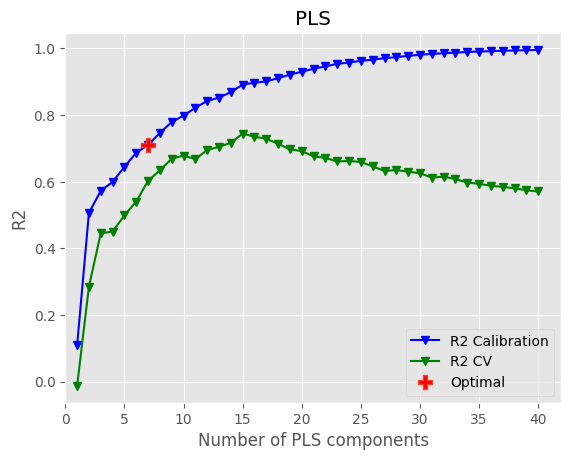

R2 calib: 0.711
R2 CV: 0.603
RMSE calib: 1.347
RMSE CV: 1.578
MSE calib: 1.814
MSE CV: 2.490
RPD: 1.993


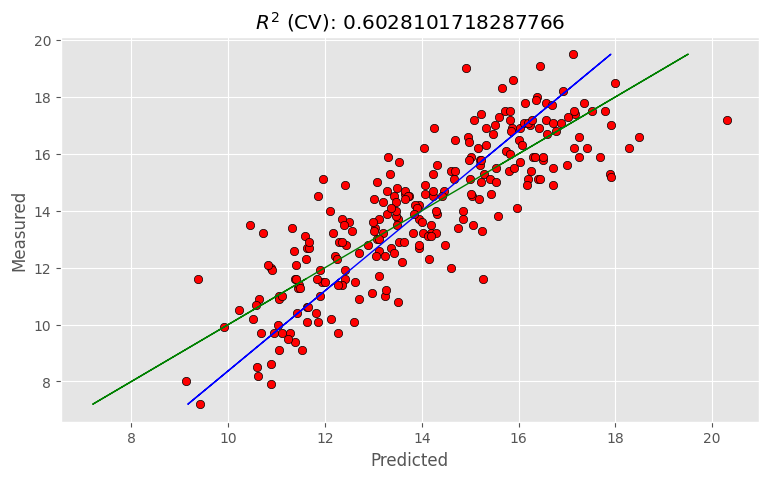

In [74]:
optimise_pls_cv(X,y_sst, 40, plot_components=True)

100% completed
Suggested number of components:  12



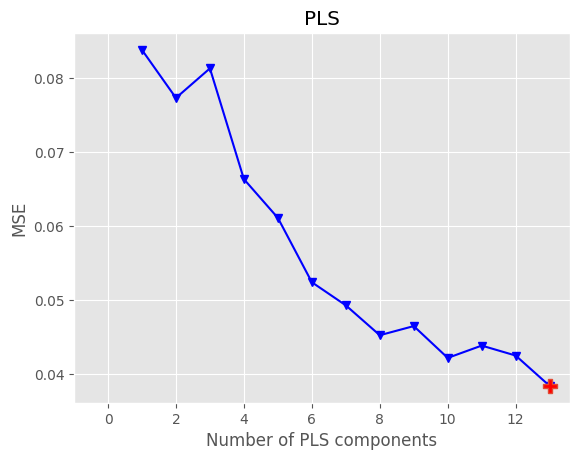

R2 calib: 0.733
R2 CV: 0.465
RMSE calib: 0.138
RMSE CV: 0.196
MSE calib: 0.019
MSE CV: 0.038
RPD: 1.367


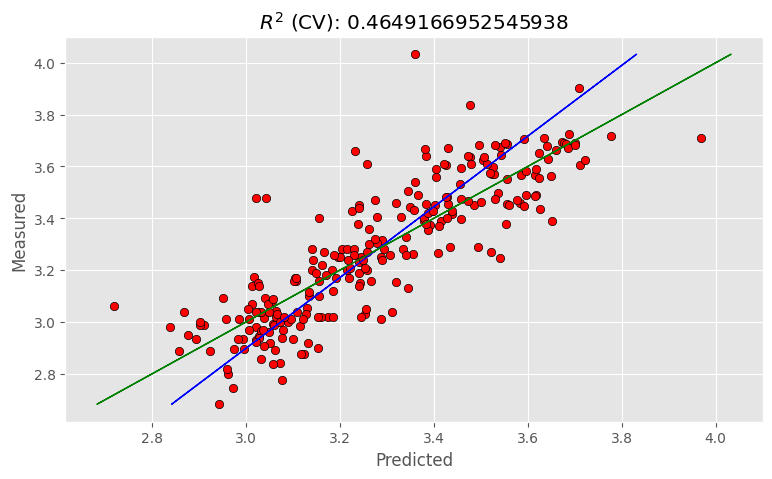

In [42]:
optimise_pls_cv(X,y_ph, 14, plot_components=True)

100% completed
Suggested number of components:  19



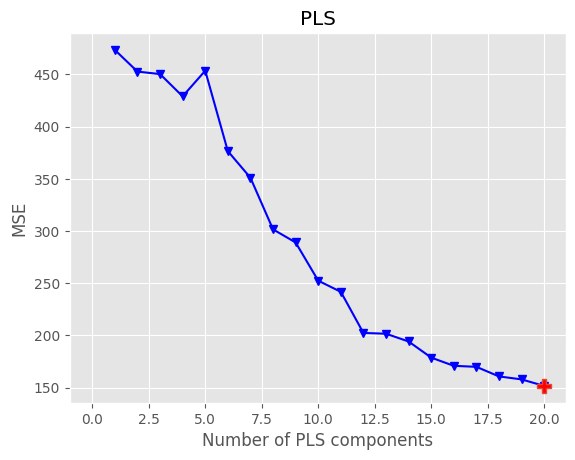

R2 calib: 0.960
R2 CV: 0.735
RMSE calib: 4.768
RMSE CV: 12.315
MSE calib: 22.734
MSE CV: 151.649
RPD: 1.944


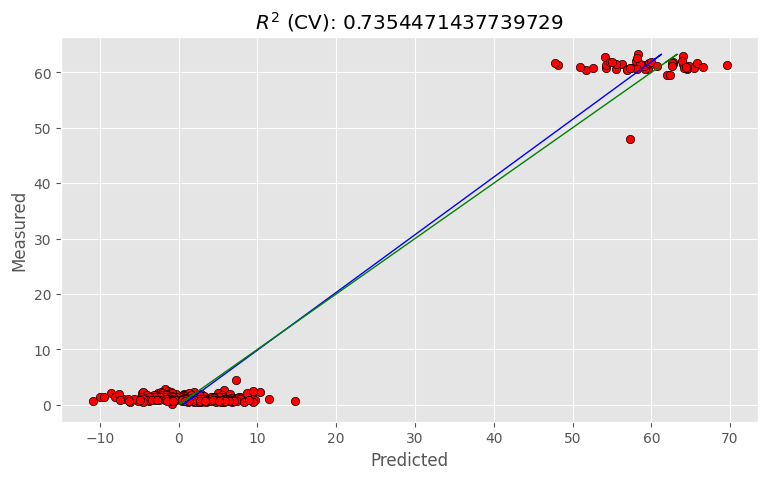

In [60]:
optimise_pls_cv(X,y_at, 21, plot_components=True)

100% completed
Suggested number of components:  14



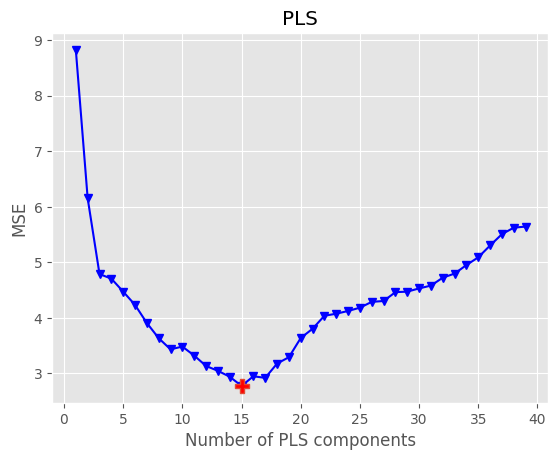

R2 calib: 0.837
R2 CV: 0.679
RMSE calib: 1.187
RMSE CV: 1.666
MSE calib: 1.410
MSE CV: 2.775
RPD: 1.766


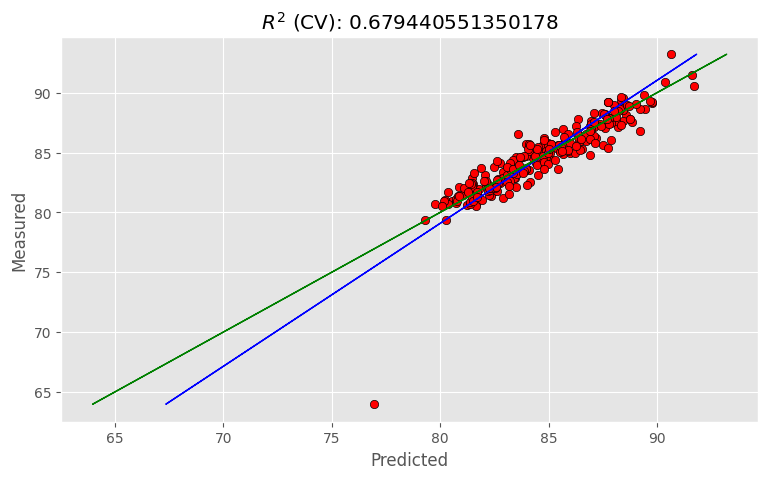

In [9]:
optimise_pls_cv(X,y_ubu, 40, plot_components=True)

100% completed
Suggested number of components:  14



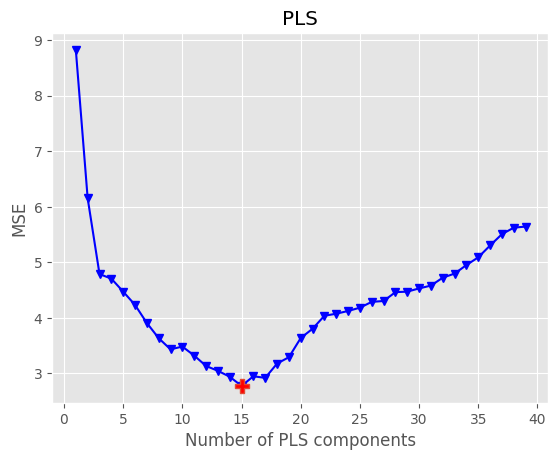

R2 calib: 0.837
R2 CV: 0.679
RMSE calib: 1.187
RMSE CV: 1.666
MSE calib: 1.410
MSE CV: 2.775
RPD: 1.766


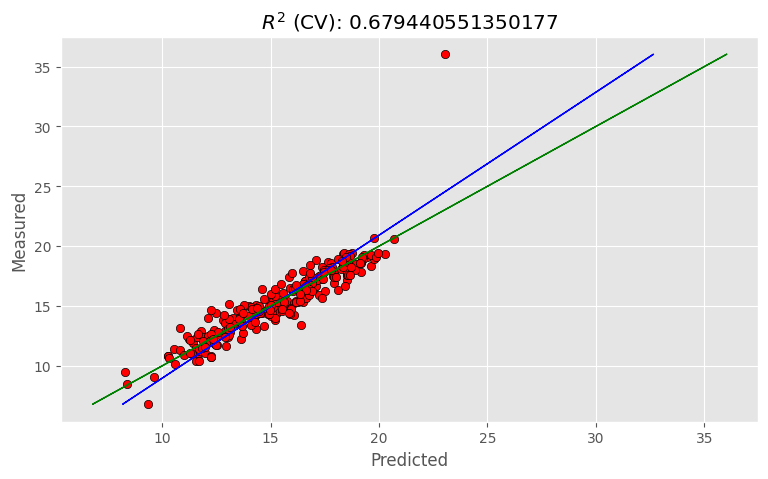

In [10]:
optimise_pls_cv(X,y_ubs, 40, plot_components=True)

# PLSR - MSC

In [11]:
# Get reference values
y_sst = df_raw['SST'].values
y_ph = df_raw['PH'].values
y_at = df_raw['AT'].values
y_fn = df_raw['FIRMEZA (N)'].values
y_ubu = df_raw['UBU (%)'].values
y_ubs = df_raw['UBS (%)'].values
# Get spectra
X_msc = df_msc.values
# Get wavelengths
wl = np.arange(350,2500,1)

100% completed
Suggested number of components:  13



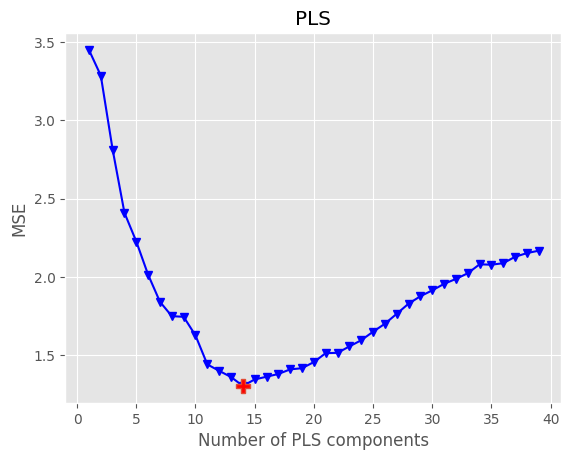

R2 calib: 0.904
R2 CV: 0.792
RMSE calib: 0.775
RMSE CV: 1.142
MSE calib: 0.601
MSE CV: 1.304
RPD: 2.192


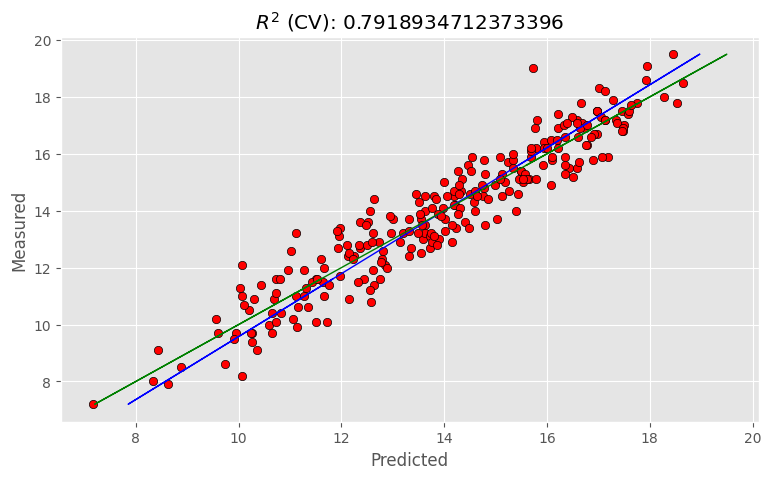

In [12]:
optimise_pls_cv(X_msc,y_sst, 40, plot_components=True)

100% completed
Suggested number of components:  20



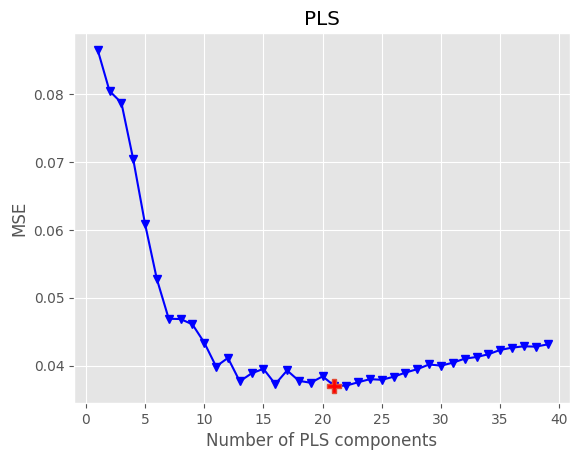

R2 calib: 0.921
R2 CV: 0.485
RMSE calib: 0.075
RMSE CV: 0.192
MSE calib: 0.006
MSE CV: 0.037
RPD: 1.393


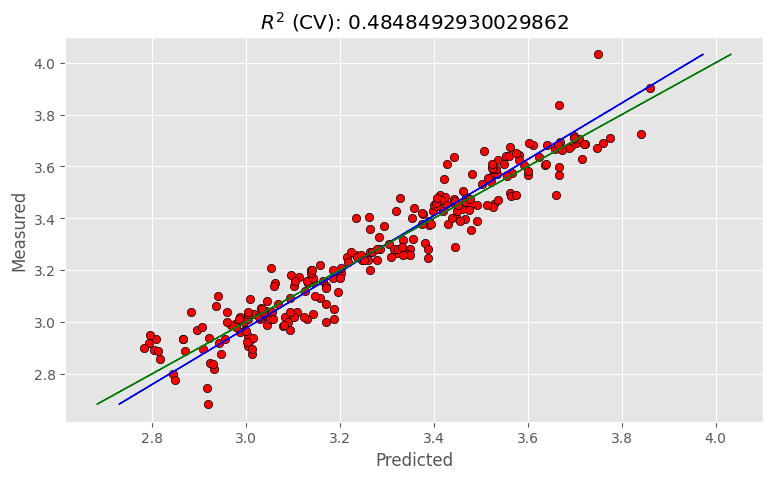

In [13]:
optimise_pls_cv(X_msc,y_ph, 40, plot_components=True)

100% completed
Suggested number of components:  20



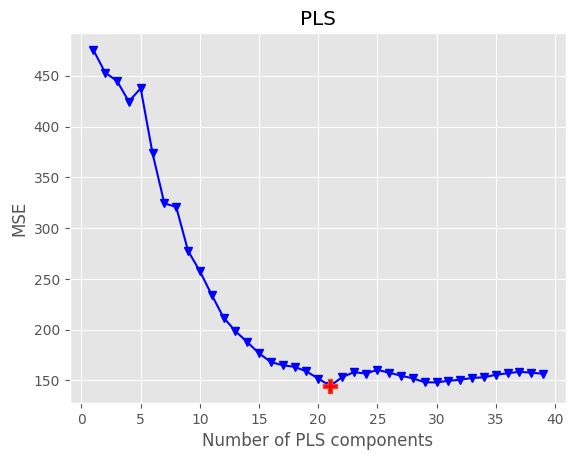

R2 calib: 0.969
R2 CV: 0.748
RMSE calib: 4.227
RMSE CV: 12.021
MSE calib: 17.864
MSE CV: 144.510
RPD: 1.992


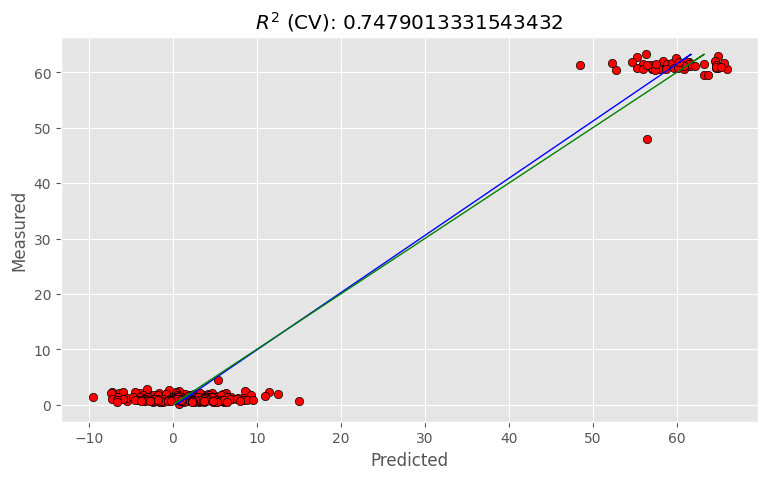

In [14]:
optimise_pls_cv(X_msc,y_at, 40, plot_components=True)

100% completed
Suggested number of components:  12



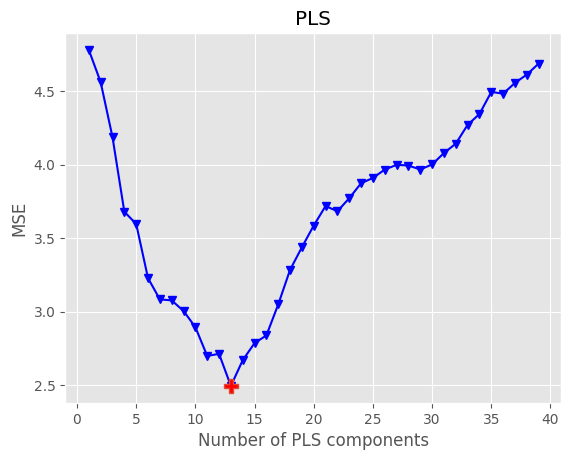

R2 calib: 0.843
R2 CV: 0.712
RMSE calib: 1.167
RMSE CV: 1.579
MSE calib: 1.361
MSE CV: 2.495
RPD: 1.863


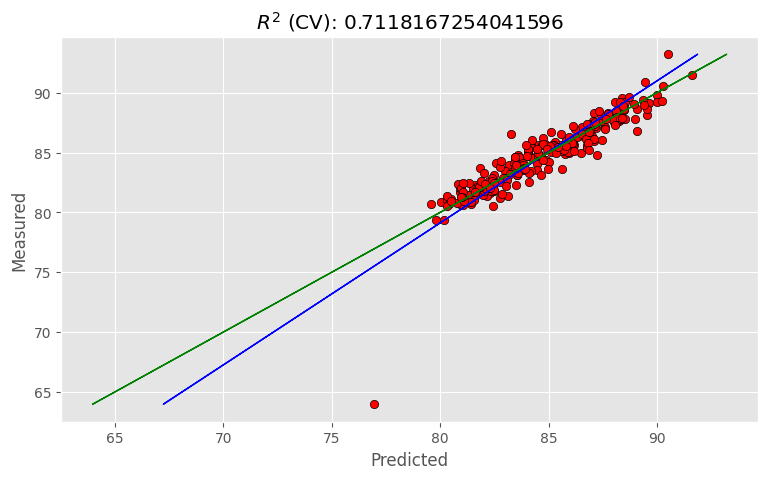

In [15]:
optimise_pls_cv(X_msc,y_ubu, 40, plot_components=True)

100% completed
Suggested number of components:  12



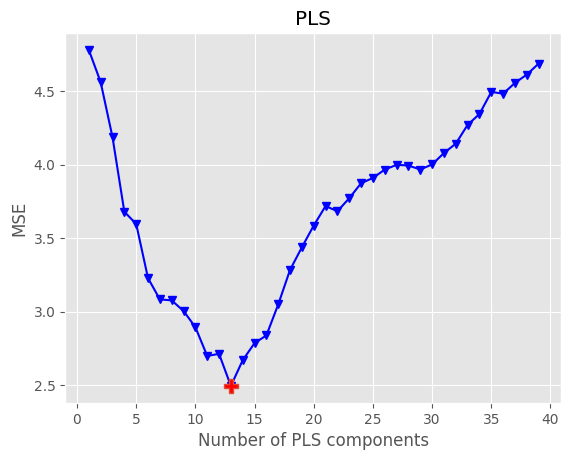

R2 calib: 0.843
R2 CV: 0.712
RMSE calib: 1.167
RMSE CV: 1.579
MSE calib: 1.361
MSE CV: 2.495
RPD: 1.863


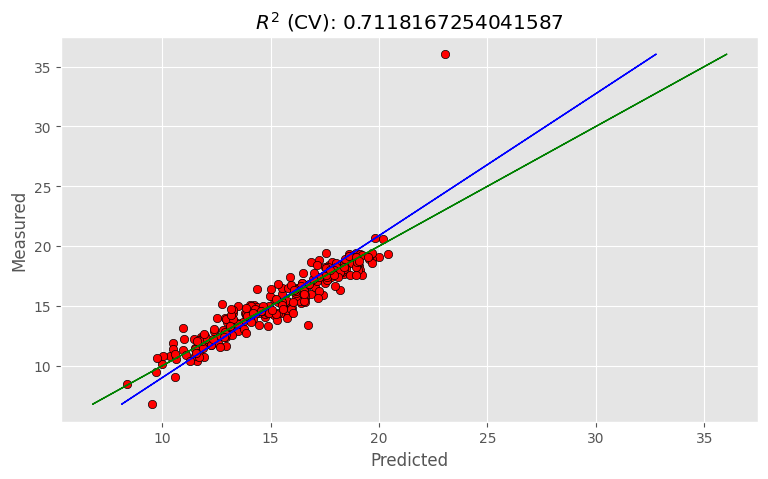

In [16]:
optimise_pls_cv(X_msc,y_ubs, 40, plot_components=True)

# PLSR - SNV

In [17]:
# Get reference values
y_sst = df_raw['SST'].values
y_ph = df_raw['PH'].values
y_at = df_raw['AT'].values
y_fn = df_raw['FIRMEZA (N)'].values
y_ubu = df_raw['UBU (%)'].values
y_ubs = df_raw['UBS (%)'].values
# Get spectra
X = df_snv.values
# Get wavelengths
wl = np.arange(350,2500,1)

100% completed
Suggested number of components:  14



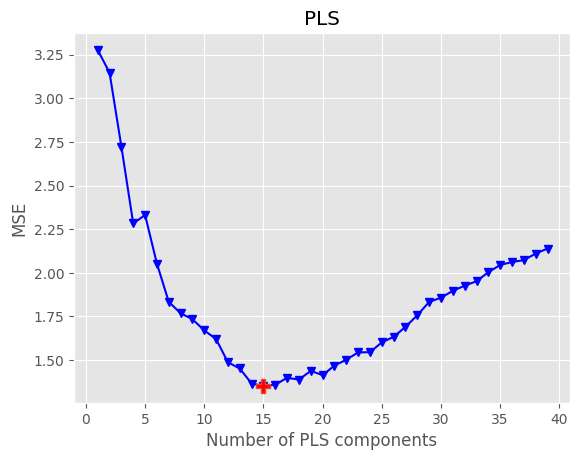

R2 calib: 0.904
R2 CV: 0.784
RMSE calib: 0.775
RMSE CV: 1.163
MSE calib: 0.600
MSE CV: 1.352
RPD: 2.153


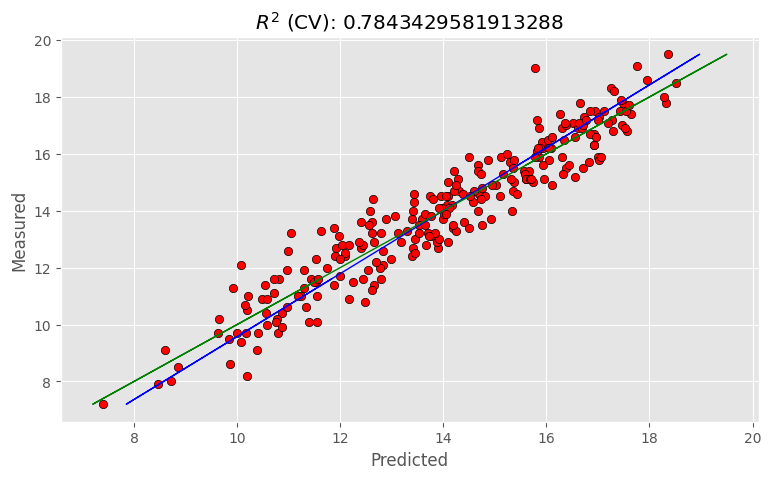

In [18]:
optimise_pls_cv(X,y_sst, 40, plot_components=True)

In [19]:
optimise_pls_cv(X,y_, 40, plot_components=True)

NameError: name 'y_' is not defined

# PLSR - SAVGOL

In [ ]:
# Get reference values
y_sst = df_raw['SST'].values
y_ph = df_raw['PH'].values
y_at = df_raw['AT'].values
y_fn = df_raw['FIRMEZA (N)'].values
y_ubu = df_raw['UBU (%)'].values
y_ubs = df_raw['UBS (%)'].values
# Get spectra
X = df_sg.values
# Get wavelengths
wl = np.arange(350,2500,1)